# Capstone Project — The Battle of Neighbourhoods

### Introduction
<p>Montreal is the second-most populous city in Canada and most populous city in the Canadian province of Quebec. In 2016, the city had a population of 1,704,694, with a population of 1,942,247 in the urban agglomeration, including all of the other municipalities on the Island of Montreal. French is the city's official language and in 2016 was the main home language of 49.8% of the population, while English was spoken by 22.8% at home, and 18.3% spoke other languages</p> 

<p> Indoors and outdoors pools in Montreal are the perfect places to go, especially in summer. They are among the best free things to do in Montreal for all ages and numbers in among the best things to do with kids.</p>

The goal of the project is to check if there are enough pools in Montreal and incidentally if the order of importance of parks and restaurants.We want to study how they are distributed on the Montreal island, and to check if there are enough in disadvantaged neighbourhoods.

So as part of this project , we will list and visualise all major parts of Montreal.
   </p>

 ### Questions that can be asked using the above mentioned datasets
- What is best location in Montreal City for pool swimming ? 
- Which areas have less pools ? 
- What is the relationship between availabality of pools, and mean population age ?
- Analyse the disadvantaged neighbourhoods in order to propose building new pools in these areas ?


### Data
For this project we need the following data :
<ul>
<li> Montreal pools data that contains list Locality, pool name,type (indoor, outdoor) along with their latitude and longitude.
<li> Montreal Census data,2016 that contains statistics by neiborhood.
    <ul>
        <li>Data source : <a href="https://donnees.montreal.ca/">Open data, Montreal city</a>
 <li> Description : This data set contains the required information. And we will use this data set to explore various locality of Montreal.
     </ul>
<li> Nearby places in each locality of Montreal.
        <ul>
            <li>Data source : <a href="https://developer.foursquare.com/"> Fousquare API </a>
        <li> Description : By using this api we will get all the venues in each neighborhood. 
    

### Approach
- Collect the Montreal city data from <a href="https://donnees.montreal.ca/">Open data, Montreal city</a>
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are nearby by locality.
- Using aggregative rating for each pool to find the best places.
- Visualize the Ranking of neighborhoods using folium library(python)

## Install and load libraries

In [5]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#! pip install folium
import folium # map rendering library
#! pip install geocoder
import geocoder

## Read Pools data in Montreal

In [6]:
df = pd.read_csv('piscines.csv',encoding='ISO-8859-1')
df.head()


,ID_nom,TYPE,NOM,ID_Arrond,ARRONDISSE,ADRESSE,PROPRIETE,GESTION,POINT_X,POINT_Y,EQUIPEME,LONG,LAT
0,1,Indoor,Complexe sportif Claude-Robillard,1,Ahuntsic-Cartierville,"1 000, Avenue Émile-Journeault Est",Municipale,Municipale,"294151,2717",5045855457,Complexe aquatique,-73.636390,45.552526
1,2,Outdoor,Marcelin-Wilson,1,Ahuntsic-Cartierville,"1 655, Rue Dudemaine, H3M 1R2",Municipale,Municipale,"290413,3232",5044137201,NaN,-73.684215,45.537000
2,3,Indoor,Sophie-Barat,1,Ahuntsic-Cartierville,"10Â 851, Rue Saint-Charles, H2C 3H7",Municipale,Municipale,"291703,7809",5046899148,Piscine compétitive,-73.667771,45.561879
3,4,paddling pool,paddling pool du Sault-au-récollet,1,Ahuntsic-Cartierville,10550 rue St-Firmin,NaN,NaN,"292697,7281",5047948679,NaN,-73.655064,45.571336
4,5,"paddling pool, Jeux d'eau",paddling pool Ahuntsic,1,Ahuntsic-Cartierville,10555 rue Lajeunesse,NaN,NaN,"291891,1168",5046147865,NaN,-73.665343,45.555115


In [7]:
# Dimesions of the data frame
df.shape

(311, 13)

In [8]:
# Remove some columns
df=df.drop(['PROPRIETE', 'GESTION', 'EQUIPEME','POINT_X','POINT_Y'], axis=1)

# rename some colums from french to English
df.rename(columns={'ID_Arrond': 'ID_Neigh', 'ARRONDISSE': 'neighborhood'}, inplace=True)
df.head()



,ID_nom,TYPE,NOM,ID_Neigh,neighborhood,ADRESSE,LONG,LAT
0,1,Indoor,Complexe sportif Claude-Robillard,1,Ahuntsic-Cartierville,"1 000, Avenue Émile-Journeault Est",-73.636390,45.552526
1,2,Outdoor,Marcelin-Wilson,1,Ahuntsic-Cartierville,"1 655, Rue Dudemaine, H3M 1R2",-73.684215,45.537000
2,3,Indoor,Sophie-Barat,1,Ahuntsic-Cartierville,"10Â 851, Rue Saint-Charles, H2C 3H7",-73.667771,45.561879
3,4,paddling pool,paddling pool du Sault-au-récollet,1,Ahuntsic-Cartierville,10550 rue St-Firmin,-73.655064,45.571336
4,5,"paddling pool, Jeux d'eau",paddling pool Ahuntsic,1,Ahuntsic-Cartierville,10555 rue Lajeunesse,-73.665343,45.555115


## Read Census data in Montreal

In [9]:
df_Census = pd.read_csv('Recensement.csv',delimiter=';',encoding='ISO-8859-1')
# rename some colums from french to English

df_Census.rename(columns={'ID_Arrond': 'ID_Neigh', 'Arrondissement': 'neighborhood'}, inplace=True)
df_Census.head()



,ID_Neigh,neighborhood,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,Pourc_Non_Immig,Less_25000,25000_a_49999,50000_a_79999,80000_To_99999,100 000_And_More
0,1,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"
1,2,Anjou,42796,"13,7",3128.4,43.8,"33,5%","65,7%","16,1%","29,7%","25,9%","9,7%","18,7%"
2,3,Côte-des-NeigesNotre-Dame-de-Grâce,166520,"21,4",7766.8,36.1,"46,7%","46,9%","27,6%","26,8%","20,7%","7,7%","17,3%"
3,5,Lachine,44489,"17,7",2510.7,40.2,"22,5%","76,7%","21,1%","26,3%","22,3%","9,7%","20,6%"
4,6,LaSalle,76853,"16,3",4723.6,41.6,"35,9%","62,4%","18,9%","29,1%","25,1%","9,7%","17,3%"


## Merge the pools data with Census data in Montreal

In [10]:
df_complete=df.merge(df_Census, on='ID_Neigh', how='left')
df_complete.head()

,ID_nom,TYPE,NOM,ID_Neigh,neighborhood_x,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,Pourc_Non_Immig,Less_25000,25000_a_49999,50000_a_79999,80000_To_99999,100 000_And_More
0,1,Indoor,Complexe sportif Claude-Robillard,1,Ahuntsic-Cartierville,"1 000, Avenue Émile-Journeault Est",-73.636390,45.552526,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"
1,2,Outdoor,Marcelin-Wilson,1,Ahuntsic-Cartierville,"1 655, Rue Dudemaine, H3M 1R2",-73.684215,45.537000,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"
2,3,Indoor,Sophie-Barat,1,Ahuntsic-Cartierville,"10Â 851, Rue Saint-Charles, H2C 3H7",-73.667771,45.561879,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"
3,4,paddling pool,paddling pool du Sault-au-récollet,1,Ahuntsic-Cartierville,10550 rue St-Firmin,-73.655064,45.571336,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"
4,5,"paddling pool, Jeux d'eau",paddling pool Ahuntsic,1,Ahuntsic-Cartierville,10555 rue Lajeunesse,-73.665343,45.555115,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%","57,9%","21,9%","27,0%","22,9%","9,1%","19,1%"


In [11]:
df_complete.shape

(311, 20)

### created map to show the pool cluters 

In [12]:
Montreal_Pools = folium.Map(location=[45.5016889, -73.567256], zoom_start=10)

X = df_complete['LAT']
Y = df_complete['LONG']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=3, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow','orange']
df_complete ['Cluster'] = clusters

for latitude, longitude, Locality, cluster in zip(df_complete['LAT'], df_complete['LONG'], df_complete['neighborhood_x'], df_complete['Cluster']):
    label = folium.Popup(Locality, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(Montreal_Pools)  

Montreal_Pools

## Which neighborhood​s have the more pools?

Text(0, 0.5, 'Number of pools')

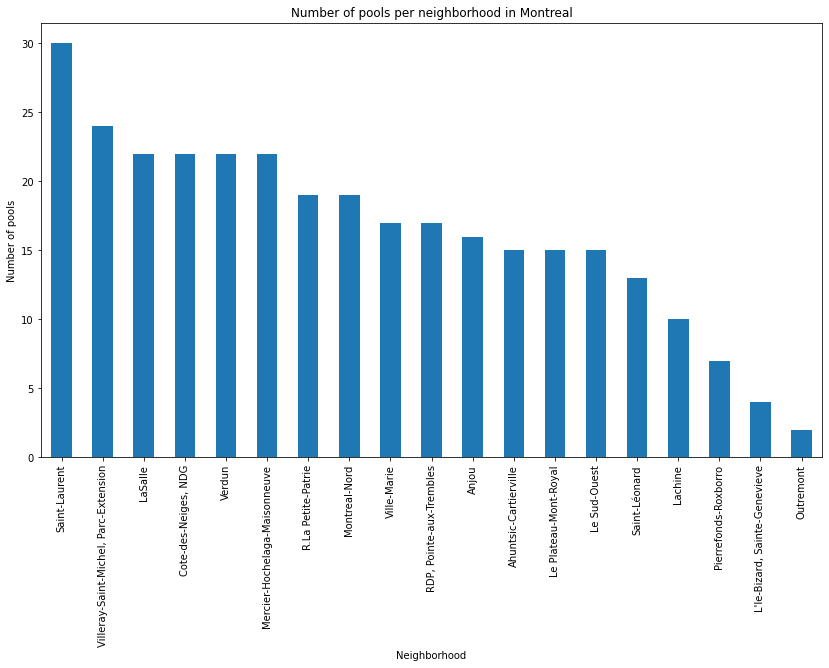

In [13]:
ax = df_complete['neighborhood_x'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of pools per neighborhood in Montreal")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of pools")

In [14]:
Nb_pools=df_complete['neighborhood_x'].value_counts()
Nb_pools.sort_index(inplace=True)

popDize_Neiborhood=df_complete.groupby('neighborhood_x')['Population_2016'].mean()
popDize_Neiborhood.sort_index(inplace=True)

In [15]:
# Number of pools per neighberhoods
Nb_pools

Ahuntsic-Cartierville                    15
Anjou                                    16
Cote-des-Neiges, NDG                     22
L'Ie-Bizard, Sainte-Genevieve             4
LaSalle                                  22
Lachine                                  10
Le Plateau-Mont-Royal                    15
Le Sud-Ouest                             15
Mercier-Hochelaga-Maisonneuve            22
Montreal-Nord                            19
Outremont                                 2
Pierrefonds-Roxborro                      7
R.La Petite-Patrie                       19
RDP, Pointe-aux-Trembles                 17
Saint-Laurent                            30
Saint-Léonard                            13
Verdun                                   22
Ville-Marie                              17
Villeray-Saint-Michel, Parc-Extension    24
Name: neighborhood_x, dtype: int64

In [16]:
popDize_Neiborhood

neighborhood_x
Ahuntsic-Cartierville                    134245
Anjou                                     42796
Cote-des-Neiges, NDG                     166520
L'Ie-Bizard, Sainte-Genevieve             18413
LaSalle                                   76853
Lachine                                   44489
Le Plateau-Mont-Royal                    104000
Le Sud-Ouest                              78151
Mercier-Hochelaga-Maisonneuve            136024
Montreal-Nord                             84234
Outremont                                 23954
Pierrefonds-Roxborro                      69297
R.La Petite-Patrie                       139590
RDP, Pointe-aux-Trembles                 106743
Saint-Laurent                             98828
Saint-Léonard                             78305
Verdun                                    69229
Ville-Marie                               89170
Villeray-Saint-Michel, Parc-Extension    143853
Name: Population_2016, dtype: int64

In [17]:
# List of neighberhoods
index = Nb_pools.index

a_list = list(index)
a_list

['Ahuntsic-Cartierville',
 'Anjou',
 'Cote-des-Neiges, NDG',
 "L'Ie-Bizard, Sainte-Genevieve",
 'LaSalle',
 'Lachine',
 'Le Plateau-Mont-Royal',
 'Le Sud-Ouest',
 'Mercier-Hochelaga-Maisonneuve',
 'Montreal-Nord',
 'Outremont',
 'Pierrefonds-Roxborro',
 'R.La Petite-Patrie',
 'RDP, Pointe-aux-Trembles',
 'Saint-Laurent',
 'Saint-Léonard',
 'Verdun',
 'Ville-Marie',
 'Villeray-Saint-Michel, Parc-Extension']

## Relationship between number of pools and population size

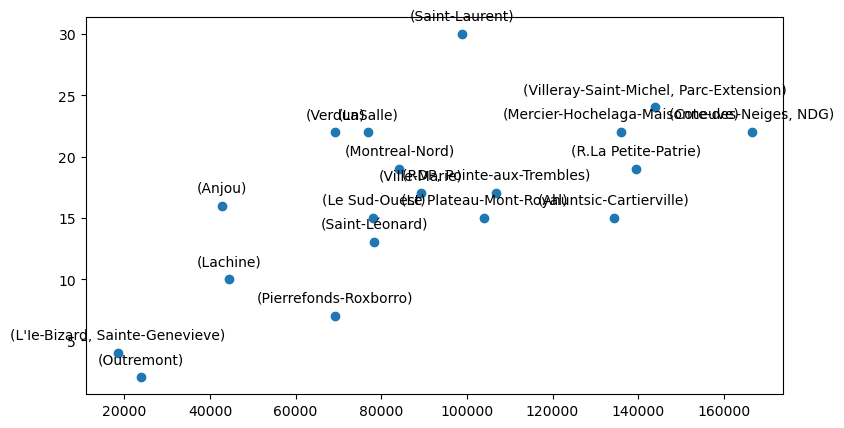

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
plt.scatter(popDize_Neiborhood,Nb_pools)

# zip joins x and y coordinates in pairs
for x,y,z in zip(popDize_Neiborhood,Nb_pools,a_list):

    label = f"({z})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') #


plt.show()

In [19]:
# Density of the population

df_complete.dtypes
df_complete.head()
df_complete["Density"] = (df_complete["Density"]).astype(float)

Density_Neighborhood=df_complete.groupby('neighborhood_x')['Density'].mean()
Density_Neighborhood.sort_index(inplace=True)
Density_Neighborhood

neighborhood_x
Ahuntsic-Cartierville                     5556.5
Anjou                                     3128.4
Cote-des-Neiges, NDG                      7766.8
L'Ie-Bizard, Sainte-Genevieve              780.2
LaSalle                                   4723.6
Lachine                                   2510.7
Le Plateau-Mont-Royal                    12792.1
Le Sud-Ouest                              4984.1
Mercier-Hochelaga-Maisonneuve             5353.2
Montreal-Nord                             7623.0
Outremont                                 6221.8
Pierrefonds-Roxborro                      2560.9
R.La Petite-Patrie                        8806.9
RDP, Pointe-aux-Trembles                  2524.7
Saint-Laurent                             2310.7
Saint-Léonard                             5804.7
Verdun                                    7126.0
Ville-Marie                               5397.7
Villeray-Saint-Michel, Parc-Extension     8723.7
Name: Density, dtype: float64

## Relationship between number of pools and population density

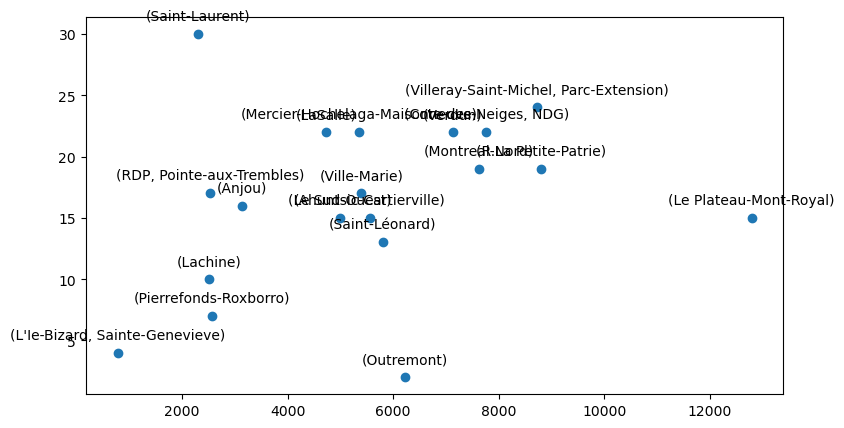

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
plt.scatter(Density_Neighborhood,Nb_pools)

# zip joins x and y coordinates in pairs
for x,y,z in zip(Density_Neighborhood,Nb_pools,a_list):

    label = f"({z})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') #


plt.show()

In [21]:
# Density of the population

df_complete["Age_Median"] = (df_complete["Age_Median"]).astype(float)

Age_Median_Neighborhood=df_complete.groupby('neighborhood_x')['Age_Median'].mean()
Age_Median_Neighborhood.sort_index(inplace=True)
Age_Median_Neighborhood


neighborhood_x
Ahuntsic-Cartierville                    39.9
Anjou                                    43.8
Cote-des-Neiges, NDG                     36.1
L'Ie-Bizard, Sainte-Genevieve            43.1
LaSalle                                  41.6
Lachine                                  40.2
Le Plateau-Mont-Royal                    33.6
Le Sud-Ouest                             35.7
Mercier-Hochelaga-Maisonneuve            38.5
Montreal-Nord                            40.0
Outremont                                36.1
Pierrefonds-Roxborro                     41.0
R.La Petite-Patrie                       37.4
RDP, Pointe-aux-Trembles                 42.8
Saint-Laurent                            38.1
Saint-Léonard                            40.6
Verdun                                   38.9
Ville-Marie                              34.5
Villeray-Saint-Michel, Parc-Extension    36.0
Name: Age_Median, dtype: float64

## Relationship between number of pools and median age

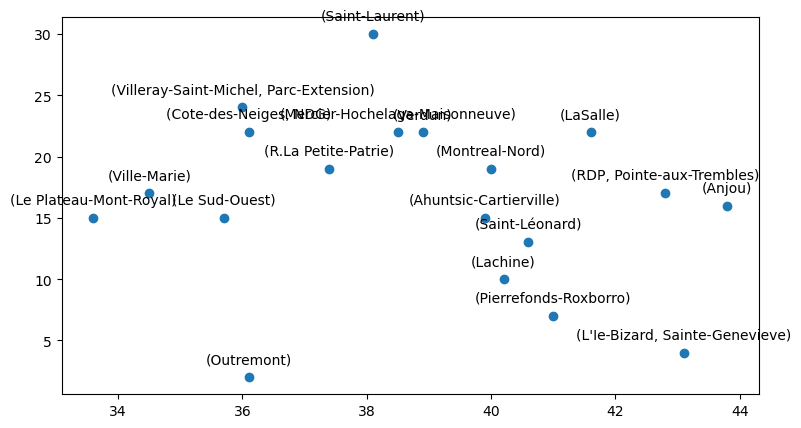

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
plt.scatter(Age_Median_Neighborhood,Nb_pools)

# zip joins x and y coordinates in pairs
for x,y,z in zip(Age_Median_Neighborhood,Nb_pools,a_list):

    label = f"({z})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') #


plt.show()

## Define Foursquare Credentials and Version

In [23]:
## Define Foursquare Credentials and Version
CLIENT_ID = 'KF4FH0AUQSFXUFCA5UMOI14KMQILWL0XJL0IBV5OA4PQBS5P' # your Foursquare ID
CLIENT_SECRET = 'HC1SQULWMVG2LWH2RPVAPEOUPHH4P0THTP343XNTUSMY5DQX' # your Foursquare Secret
ACCESS_TOKEN = 'EEVRVWYLCY01AWQM01UOGFJ0PQ3S3325S4PRWWYNAEX3WJ1L' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KF4FH0AUQSFXUFCA5UMOI14KMQILWL0XJL0IBV5OA4PQBS5P
CLIENT_SECRET:HC1SQULWMVG2LWH2RPVAPEOUPHH4P0THTP343XNTUSMY5DQX


## create a function to repeat the same process to all Montreal

In [24]:
## create a function to repeat the same process to all the Locality in New Delhi

def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## find the venues in all Montreal

In [26]:
# find the venues in all Montreal Locality
new_Montreal_venues = getNearbyVenues(names=df_complete['neighborhood_x'],
                                   latitudes=df_complete['LAT'],
                                   longitudes=df_complete['LONG']
                                  )

Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Ahuntsic-Cartierville
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Anjou
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
Cote-des-Neiges, NDG
L'Ie-Bizard, Sainte-Genevieve
L'Ie-Bizard, Sainte-Genevieve
L'Ie-Bizard, Sainte-Genevieve
L'Ie-Bizard, Sainte-Ge

In [29]:
new_Montreal_venues.head()

,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahuntsic-Cartierville,45.552526,-73.63639,Complexe Sportif Claude-Robillard,45.553036,-73.636036,Athletics & Sports
1,Ahuntsic-Cartierville,45.552526,-73.63639,Patate Rouge,45.548892,-73.636248,Fast Food Restaurant
2,Ahuntsic-Cartierville,45.552526,-73.63639,Crèmerie Châteaubriand,45.548237,-73.635770,Ice Cream Shop
3,Ahuntsic-Cartierville,45.552526,-73.63639,Tim Hortons,45.548678,-73.634640,Coffee Shop
4,Ahuntsic-Cartierville,45.552526,-73.63639,Parc Saint-Alphonse,45.548799,-73.639169,Park


In [30]:
new_Montreal_venues.groupby('Locality').count()

,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Locality,,,,,,
Ahuntsic-Cartierville,138,138,138,138,138,138
Anjou,75,75,75,75,75,75
"Cote-des-Neiges, NDG",411,411,411,411,411,411
"L'Ie-Bizard, Sainte-Genevieve",24,24,24,24,24,24
LaSalle,142,142,142,142,142,142
Lachine,39,39,39,39,39,39
Le Plateau-Mont-Royal,581,581,581,581,581,581
Le Sud-Ouest,289,289,289,289,289,289
Mercier-Hochelaga-Maisonneuve,283,283,283,283,283,283


In [33]:
## Analyze Each Locality

# one hot encoding
new_Montreal_onehot = pd.get_dummies(new_Montreal_venues[['Venue Category']], prefix="", prefix_sep="")

# add Locality column back to dataframe
new_Montreal_onehot['Locality'] = new_Montreal_venues['Locality'] 

# move Locality column to the first column
column_list = new_Montreal_onehot.columns.tolist()
column_number = int(column_list.index('Locality'))
column_list = [column_list[column_number]] + column_list[:column_number] + column_list[column_number+1:]
new_Montreal_onehot = new_Montreal_onehot[column_list]

new_Montreal_onehot.head()

,Locality,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Ahuntsic-Cartierville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ahuntsic-Cartierville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ahuntsic-Cartierville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ahuntsic-Cartierville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ahuntsic-Cartierville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
New_Montreal_grouped = new_Montreal_onehot.groupby('Locality').mean().reset_index()
New_Montreal_grouped

,Locality,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Ahuntsic-Cartierville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007246,0.014493,0.000000,0.000000,0.007246,0.000000,0.000000,0.000000,0.000000
1,Anjou,0.000000,0.000000,0.000000,0.000000,0.026667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Cote-des-Neiges, NDG",0.000000,0.000000,0.000000,0.000000,0.007299,0.000000,0.000000,0.007299,0.000000,...,0.000000,0.000000,0.034063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"L'Ie-Bizard, Sainte-Genevieve",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,LaSalle,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Lachine,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Le Plateau-Mont-Royal,0.000000,0.000000,0.001721,0.003442,0.000000,0.000000,0.000000,0.006885,0.000000,...,0.000000,0.003442,0.010327,0.000000,0.001721,0.001721,0.001721,0.000000,0.008606,0.000000
7,Le Sud-Ouest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003460,0.000000,...,0.000000,0.000000,0.010381,0.000000,0.000000,0.003460,0.000000,0.000000,0.010381,0.000000
8,Mercier-Hochelaga-Maisonneuve,0.021201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003534,0.003534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Montreal-Nord,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009009,0.000000,0.027027,0.009009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
New_Montreal_grouped.shape

(19, 292)

In [36]:
## print each Locality along with the top 5 most common venues

num_top_venues = 5

for hood in New_Montreal_grouped['Locality']:
    print("----"+hood+"----")
    temp = New_Montreal_grouped[New_Montreal_grouped['Locality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ahuntsic-Cartierville----
           venue  freq
0           Park  0.08
1       Pharmacy  0.06
2     Restaurant  0.05
3  Grocery Store  0.04
4           Café  0.04


----Anjou----
                  venue  freq
0     Convenience Store  0.11
1              Pharmacy  0.08
2           Coffee Shop  0.07
3  Fast Food Restaurant  0.07
4           Pizza Place  0.07


----Cote-des-Neiges, NDG----
                  venue  freq
0           Coffee Shop  0.05
1              Pharmacy  0.04
2  Fast Food Restaurant  0.04
3         Grocery Store  0.04
4           Gas Station  0.03


----L'Ie-Bizard, Sainte-Genevieve----
                      venue  freq
0               Pizza Place  0.17
1  Mediterranean Restaurant  0.08
2                      Park  0.08
3                     Diner  0.08
4              Burger Joint  0.08


----LaSalle----
                  venue  freq
0  Fast Food Restaurant  0.08
1        Sandwich Place  0.08
2           Pizza Place  0.06
3              Pharmacy  0.06
4         Gro

In [37]:
## put that into a pandas dataframe
## First, write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
## create the new dataframe and display the top 10 venues for each Locality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Locality_venues_sorted = pd.DataFrame(columns=columns)
Locality_venues_sorted['Locality'] = New_Montreal_grouped['Locality']

for ind in np.arange(New_Montreal_grouped.shape[0]):
    Locality_venues_sorted.iloc[ind, 1:] = return_most_common_venues(New_Montreal_grouped.iloc[ind, :], num_top_venues)

Locality_venues_sorted

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahuntsic-Cartierville,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
1,Anjou,Convenience Store,Pharmacy,Fast Food Restaurant,Pizza Place,Coffee Shop,Supermarket,Gas Station,BBQ Joint,Soccer Field,Sandwich Place
2,"Cote-des-Neiges, NDG",Coffee Shop,Fast Food Restaurant,Grocery Store,Pharmacy,Middle Eastern Restaurant,Vietnamese Restaurant,Pizza Place,Bakery,Café,Gas Station
3,"L'Ie-Bizard, Sainte-Genevieve",Pizza Place,Construction & Landscaping,Grocery Store,Fast Food Restaurant,Mediterranean Restaurant,Diner,Performing Arts Venue,Convenience Store,Burger Joint,Ice Cream Shop
4,LaSalle,Sandwich Place,Fast Food Restaurant,Pharmacy,Pizza Place,Grocery Store,Discount Store,Ice Cream Shop,Shopping Mall,Skating Rink,Gym / Fitness Center
5,Lachine,Park,Fast Food Restaurant,Pizza Place,Storage Facility,Pharmacy,Skating Rink,Falafel Restaurant,Gun Range,Tunnel,Coffee Shop
6,Le Plateau-Mont-Royal,Café,Bar,Bakery,French Restaurant,Park,Portuguese Restaurant,Coffee Shop,Pizza Place,Breakfast Spot,Vegetarian / Vegan Restaurant
7,Le Sud-Ouest,Restaurant,Café,Pizza Place,Breakfast Spot,Ice Cream Shop,French Restaurant,Park,Grocery Store,Pharmacy,Bakery
8,Mercier-Hochelaga-Maisonneuve,Pharmacy,Coffee Shop,Restaurant,Park,Pizza Place,Fast Food Restaurant,Ice Cream Shop,French Restaurant,Bakery,Hardware Store
9,Montreal-Nord,Fast Food Restaurant,Italian Restaurant,Gas Station,Pharmacy,Sandwich Place,Park,Restaurant,Skating Rink,Grocery Store,Gastropub


In [56]:
## Cluster Locality
## Run k-means to cluster the Locality into 5 clusters.

# set number of clusters
kclusters = 5

New_Montreal_clustering = New_Montreal_grouped.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(New_Montreal_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
kmeans.labels_.shape

(19,)

In [57]:
# add clustering labels
New_Montreal_merged = df_complete.head(19)
New_Montreal_merged.rename(columns={'neighborhood_x': 'Locality'}, inplace=True)

New_Montreal_merged['Cluster Labels'] = kmeans.labels_

# merge New_Montreal_grouped with df_Chinese to add latitude/longitude for each Locality
New_Montreal_merged = New_Montreal_merged.join(Locality_venues_sorted.set_index('Locality'), on='Locality')

New_Montreal_merged.head()

C:\Users\sadou\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-57-23cbe890f411>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_Montreal_merged['Cluster Labels'] = kmeans.labels_


,ID_nom,TYPE,NOM,ID_Neigh,Locality,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Indoor,Complexe sportif Claude-Robillard,1,Ahuntsic-Cartierville,"1 000, Avenue Émile-Journeault Est",-73.636390,45.552526,Ahuntsic-Cartierville,134245,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
1,2,Outdoor,Marcelin-Wilson,1,Ahuntsic-Cartierville,"1 655, Rue Dudemaine, H3M 1R2",-73.684215,45.537000,Ahuntsic-Cartierville,134245,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
2,3,Indoor,Sophie-Barat,1,Ahuntsic-Cartierville,"10Â 851, Rue Saint-Charles, H2C 3H7",-73.667771,45.561879,Ahuntsic-Cartierville,134245,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
3,4,paddling pool,paddling pool du Sault-au-récollet,1,Ahuntsic-Cartierville,10550 rue St-Firmin,-73.655064,45.571336,Ahuntsic-Cartierville,134245,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
4,5,"paddling pool, Jeux d'eau",paddling pool Ahuntsic,1,Ahuntsic-Cartierville,10555 rue Lajeunesse,-73.665343,45.555115,Ahuntsic-Cartierville,134245,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [58]:
# create final map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors = ['red', 'green', 'blue', 'yellow','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(New_Montreal_merged['LAT'], New_Montreal_merged['LONG'], New_Montreal_merged['Locality'], New_Montreal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [53]:
## Examine Clusters

## Cluster 1
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 0, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ID_Neigh,Locality,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,paddling pool,1,Ahuntsic-Cartierville,9300 rue St-Denis,-73.648544,45.547238,Ahuntsic-Cartierville,134245,"24,2",5556.5,...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [59]:
## Examine Clusters

## Cluster 2
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 1, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"paddling pool, water play area",12120 rue Grenet,-73.717518,45.530166,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [55]:
## Examine Clusters

## Cluster 2
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 2, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Indoor,"1 000, Avenue Émile-Journeault Est",-73.636390,45.552526,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
1,Outdoor,"1 655, Rue Dudemaine, H3M 1R2",-73.684215,45.537000,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
2,Indoor,"10Â 851, Rue Saint-Charles, H2C 3H7",-73.667771,45.561879,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
4,"paddling pool, Jeux d'eau",10555 rue Lajeunesse,-73.665343,45.555115,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
5,"paddling pool, water play area",12120 rue Grenet,-73.717518,45.530166,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
6,"Outdoor, water play area",1655 rue Dudemaine,-73.688960,45.539260,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
7,Outdoor,"2 350, Rue Sauvé Est, H2B 1B2",-73.642456,45.570705,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
8,water play area,215 Prieur Ouest,-73.670644,45.546019,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
9,water play area,260 rue Legendre O,-73.648819,45.539904,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store
10,water play area,8888 de ChÃ¢teaubrian,-73.638354,45.548970,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [60]:
## Examine Clusters

## Cluster 3
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 2, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,paddling pool,10550 rue St-Firmin,-73.655064,45.571336,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [61]:
## Examine Clusters

## Cluster 4
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 3, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,water play area,8888 de ChÃ¢teaubrian,-73.638354,45.54897,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


In [62]:
## Examine Clusters

## Cluster 5
New_Montreal_merged.loc[New_Montreal_merged['Cluster Labels'] == 4, New_Montreal_merged.columns[[1] + list(range(5, New_Montreal_merged.shape[1]))]]

,TYPE,ADRESSE,LONG,LAT,neighborhood_y,Population_2016,Superficie_km2,Density,Age_Median,Pourc_Immig,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,paddling pool,9300 rue St-Denis,-73.648544,45.547238,Ahuntsic-Cartierville,134245,"24,2",5556.5,39.9,"40,4%",...,Park,Pharmacy,Restaurant,Coffee Shop,Café,Italian Restaurant,Pizza Place,Fast Food Restaurant,Grocery Store,Clothing Store


# Conclusion

1- There are two neighborhoods for which we have less pools than it should be according to the population density: Outremont, and Plateau Mont-royal.
2- Actually, There is no correlation between the number of pools, and median age in neighborhoods. We recommend to take in consideration this parameter for future de developments.


3- Some neighborhoods, parks are not in the top 10 of venues : Anjou, Cote des neige,Lasalle, and Outremont.

4 - Some neighborhoods, parks are not in the top 10 of venues : Anjou, Cote des neiges, Lasalle, and Outremont.
